In [3]:
%load_ext autoreload
%autoreload all
import os
import re
import pandas as pd
import random
from plotting_utils import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
%matplotlib inline

In [39]:
data_path = os.path.join(os.getcwd(), "raw_data")
df_churn_modelling = pd.read_csv(f"{data_path}/Churn_Modelling.csv")
df = df_churn_modelling.copy()
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [40]:
# Change Pascal case column names to snake case to comply with python conventions
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]

In [41]:
print("Number of unique values in Geography column are:", df["geography"].nunique())
print("List of unique values in Geography column:", df.geography.unique())
print("Number of unique values in Gender column are:", df["gender"].nunique())
print("List of unique values in Gender column:", df.gender.unique())

Number of unique values in Geography column are: 3
List of unique values in Geography column: ['France' 'Spain' 'Germany']
Number of unique values in Gender column are: 2
List of unique values in Gender column: ['Female' 'Male']


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [43]:
df.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [44]:
df.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [45]:
# Create a cross-tabulation of "gender" and "age_group"
age_gender_cross = pd.crosstab(df['geography'], df['gender'])

# Print the cross-tabulation
print(age_gender_cross)


gender     Female  Male
geography              
France       2261  2753
Germany      1193  1316
Spain        1089  1388


In [46]:
# Drop unnecessary columns for data analysis
df.drop(["surname", "customer_id", "row_number"], axis=1, inplace=True)

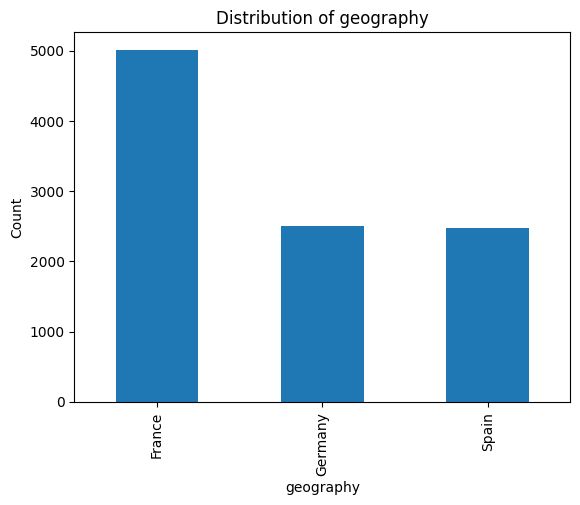

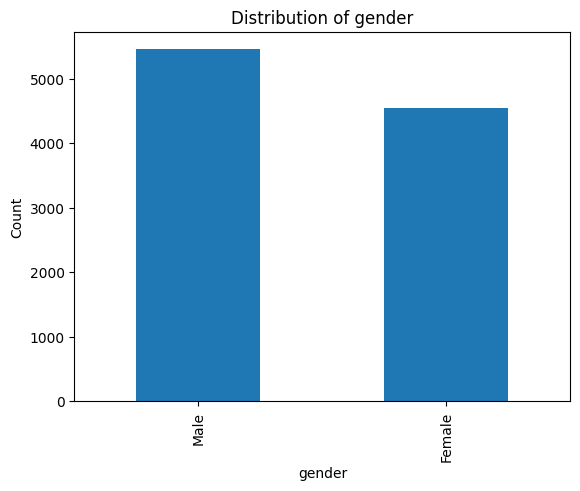

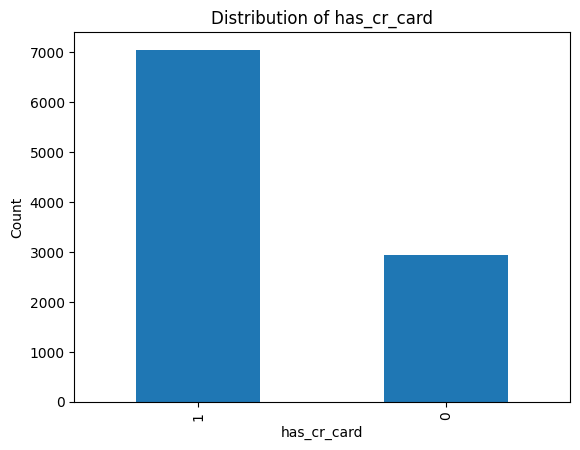

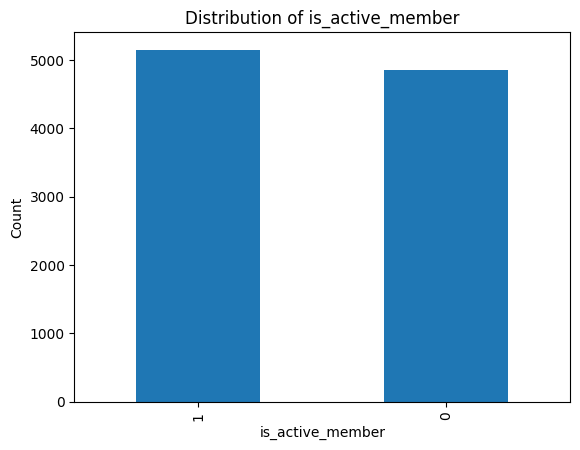

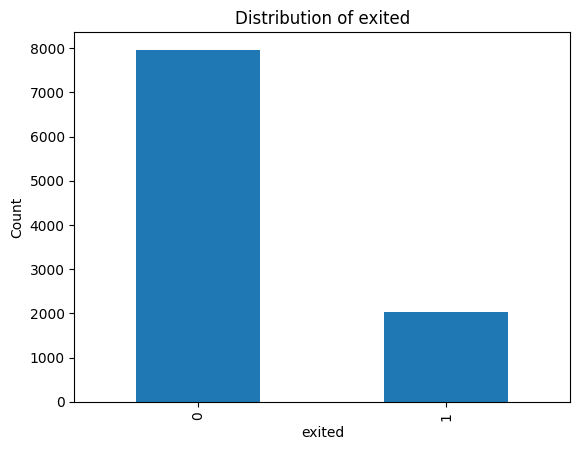

In [47]:
BarCharts.plot_bar_charts_for_each_categorical_var(df)

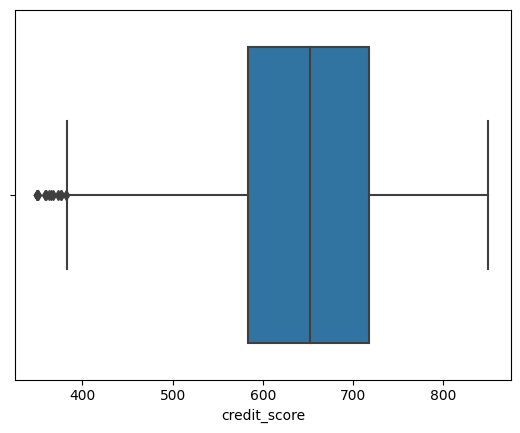

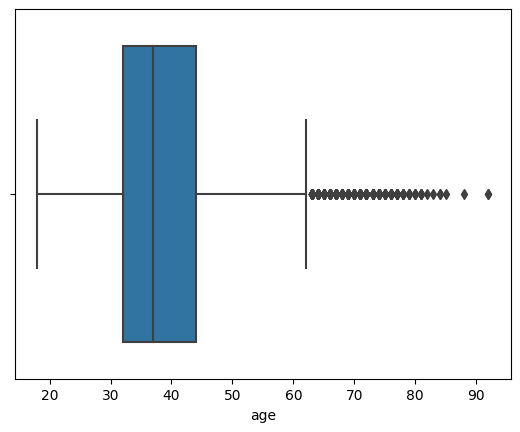

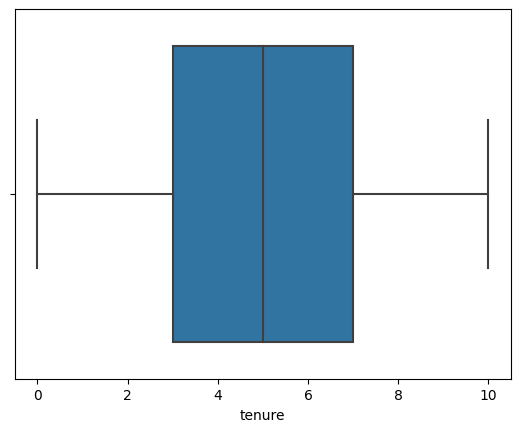

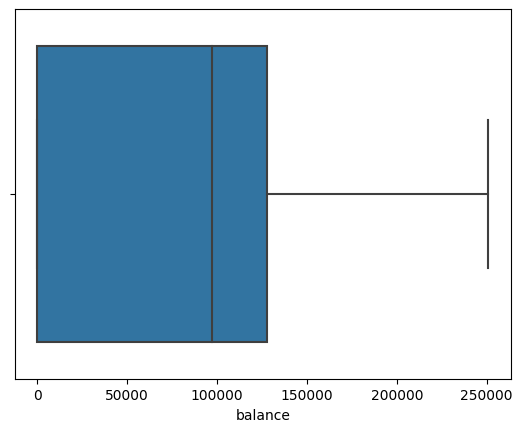

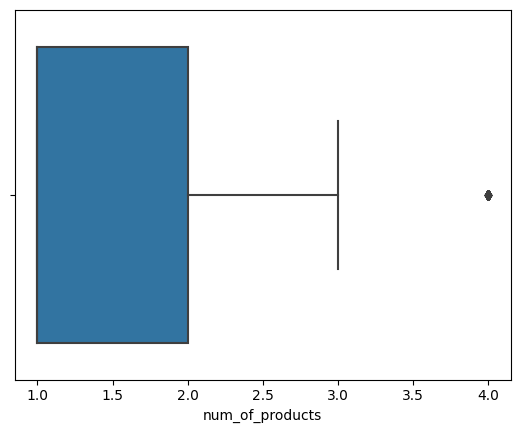

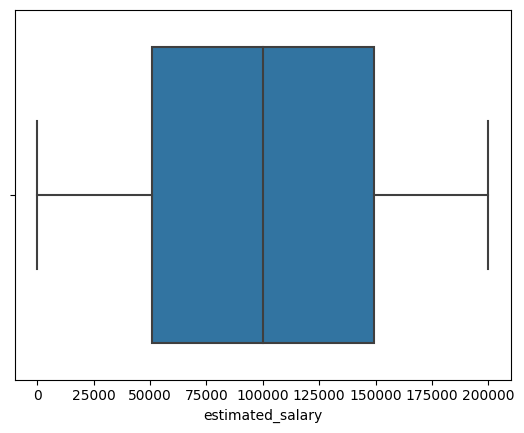

In [48]:
BoxPlots.plot_for_each_numeric_var(df)

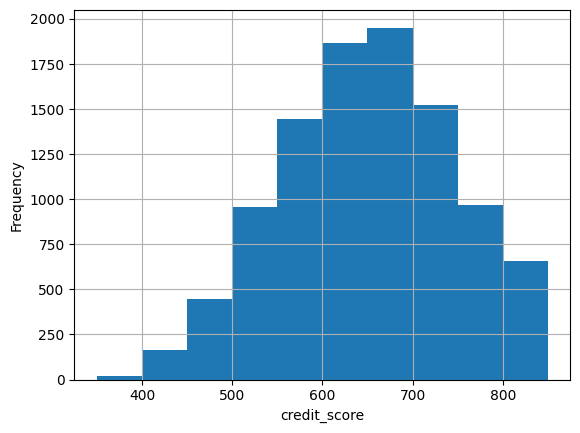

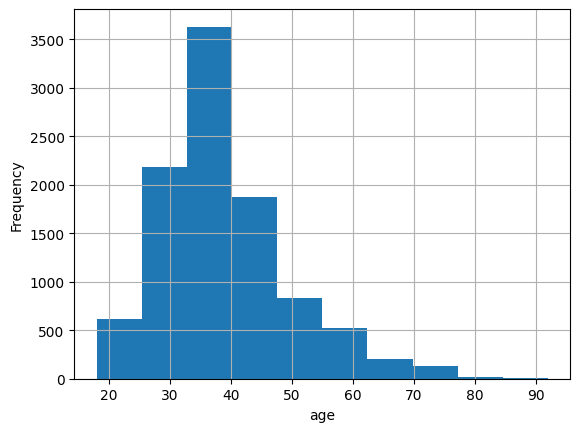

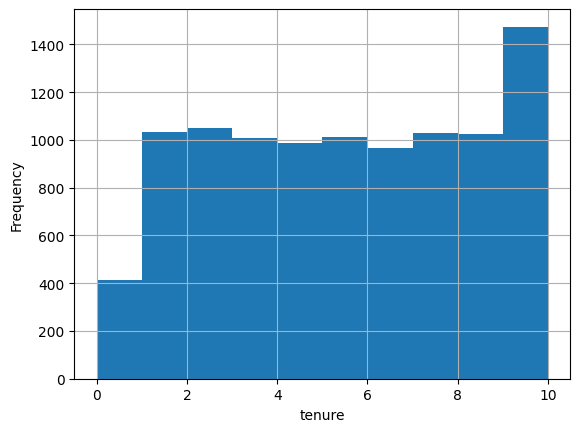

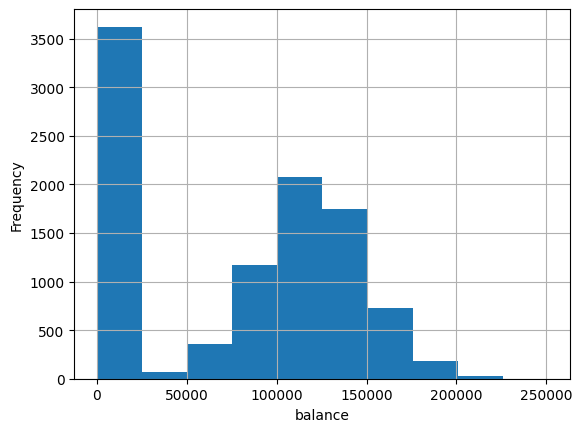

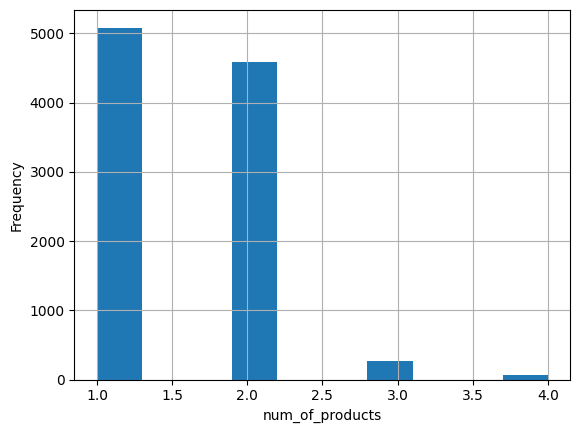

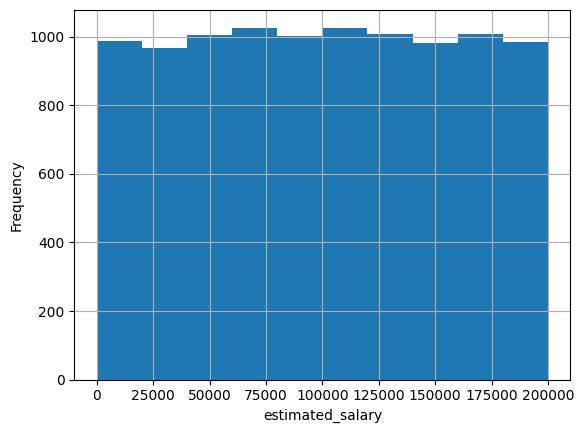

In [49]:
Histograms.plot_for_each_numeric_var(df)

In [50]:
# Convert values in the "geography" column to lowercase
df['geography'] = df['geography'].str.lower()

# Use dummy encoding to convert the "geography" column to binary variables
dummies = pd.get_dummies(df['geography'], prefix='is', prefix_sep='_', dtype=int)

# Concatenate the original DataFrame with the dummy variables
df = pd.concat([df, dummies], axis=1)

# Drop the original "geography" column
df = df.drop('geography', axis=1)

In [51]:
# replace 'Female' with 1 and 'Male' with 0
df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})

# rename the 'gender' column to 'is_female'
df = df.rename(columns={'gender': 'is_female'})

In [52]:
df_for_logistic_reg = df.copy()
df_for_random_forest = df.copy()

#### Run logistic regression without normalizing data

In [53]:
df = df_for_logistic_reg.copy()

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(df.drop("exited", axis=1), df["exited"], test_size=0.2, random_state=59)

# initialize a logistic regression model and fit it on the training data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# make predictions on the test data
y_pred = log_reg.predict(X_test)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix — Logistic reg without normalization")
print(cm)

Confusion matrix — Logistic reg without normalization
[[1557   40]
 [ 382   21]]


In [54]:
# Generate classification report
print("Classification report — Logistic reg without normalization")
print(classification_report(y_test, y_pred))

Classification report — Logistic reg without normalization
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1597
           1       0.34      0.05      0.09       403

    accuracy                           0.79      2000
   macro avg       0.57      0.51      0.49      2000
weighted avg       0.71      0.79      0.72      2000



#### Run logistic regression with normalized data

In [55]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(df.drop("exited", axis=1), df["exited"], test_size=0.2, random_state=59)

# initialize a StandardScaler object
scaler = StandardScaler()

# fit and transform the training data
X_train_norm = scaler.fit_transform(X_train)

# transform the test data using the same scaler object
X_test_norm = scaler.transform(X_test)

# initialize a logistic regression model and fit it on the normalized training data
log_reg = LogisticRegression()
log_reg.fit(X_train_norm, y_train)

# make predictions on the normalized test data
y_pred = log_reg.predict(X_test_norm)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix — Normalized logistic reg")
print(cm)

Confusion matrix — Normalized logistic reg
[[1532   65]
 [ 319   84]]


In [56]:
# Generate classification report
print("Classification report — Normalized logistic reg")
print(classification_report(y_test, y_pred))

Classification report — Normalized logistic reg
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1597
           1       0.56      0.21      0.30       403

    accuracy                           0.81      2000
   macro avg       0.70      0.58      0.60      2000
weighted avg       0.77      0.81      0.77      2000



#### Run random forest

In [57]:
df = df_for_random_forest.copy()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("exited", axis=1), df["exited"], test_size=0.2, random_state=59)

rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("Confusion matrix — Random forest")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("Classification report — Random forest")
cr = classification_report(y_test, y_pred)
print(cr)

Confusion matrix — Random forest
[[1533   64]
 [ 225  178]]
Classification report — Random forest
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1597
           1       0.74      0.44      0.55       403

    accuracy                           0.86      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.86      0.84      2000



#### Random forest with randomized search
<br>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("exited", axis=1), df["exited"], test_size=0.2, random_state=59)

param_dist = {
    'n_estimators': randint(50, 150),
    "criterion": ["gini", "entropy"],
    'max_depth': randint(5, 10),
    'class_weight': [{0: 1, 1: w} for w in [1, 4, 8]]
}

rfc = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=10, cv=5, return_train_score=True)

rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)

# fit the model using the best hyperparameters
rf_best = RandomForestClassifier(**rf_cv.best_params_, random_state=42)
rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
print("Classification Report")
cr = classification_report(y_test, y_pred)
print(cr)

{'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 8, 'n_estimators': 104}
Confusion Matrix
[[1556   41]
 [ 248  155]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1597
           1       0.79      0.38      0.52       403

    accuracy                           0.86      2000
   macro avg       0.83      0.68      0.72      2000
weighted avg       0.85      0.86      0.83      2000



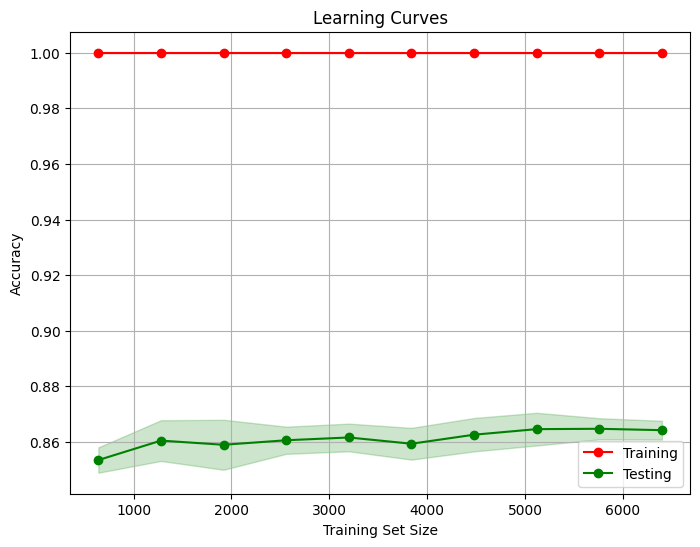

In [60]:
LearningCurve.plot_learning_curves(rfc, X_train, y_train, np.linspace(0.1, 1.0, 10), 5)

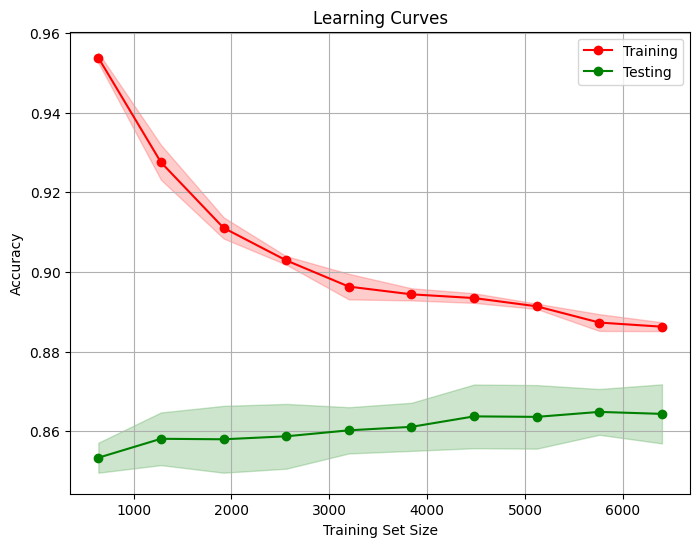

In [61]:
LearningCurve.plot_learning_curves(rf_best, X_train, y_train, np.linspace(0.1, 1.0, 10), 5)